# BLOOD GROUP DETECTION USING DEEP LEARNING ALGORITHMS(CNN) :

# Blood Detection Using Deep Learning Algorithms

## Overview  
This notebook presents a deep learning approach for blood detection using microscopic images of blood samples. The goal is to classify the blood images accurately by leveraging state-of-the-art deep learning models. Three algorithms are implemented and compared in this study:  

1. **VGG Model with Custom Blocks**  
2. **ResNet Architecture**  
3. **AlexNet Model**

## Dataset  
The dataset consists of microscopic images of blood samples. Each image is preprocessed and normalized to ensure consistency and compatibility with the deep learning models.  

## Methodology  
The notebook is structured as follows:  

### 1. **Data Preprocessing**  
- **Image Normalization**: All images are normalized to ensure pixel values fall within the range [0, 1].   

### 2. **Model 1: VGG with Custom Blocks**  
This implementation uses a modified version of the VGG architecture. The model is built using stacked convolutional layers with max-pooling operations to extract hierarchical features. Batch normalization and dropout are applied to improve generalization and reduce overfitting.  

### 3. **Model 2: ResNet Architecture**  
The ResNet model leverages residual connections to address the vanishing gradient problem. A combination of convolutional and identity blocks is used to learn deep feature representations efficiently. Dropout layers are added to further enhance the model's robustness.  

### 4. **Model 3: AlexNet**  
The AlexNet architecture is implemented as the final model. It consists of stacked convolutional layers with max-pooling operations, followed by fully connected layers. Dropout and batch normalization are applied to improve performance.  

### 5. **Training and Evaluation**  
- Each model is trained on the same dataset with the same training configuration (optimizer, learning rate, etc.).  
- Metrics such as accuracy, precision, recall, and F1-score are used to evaluate the performance on the validation and test sets.  
- Training and validation loss/accuracy are visualized to understand the learning progress of each model.  


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1. Importation des bibliothéques :

In [1]:
# import lib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Normalization
import tensorflow.keras.layers as tfl

from tensorflow.keras import layers,models
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from sklearn.metrics import confusion_matrix

### 2. Import the data set (blood dataset) :

In [2]:
# define the directory :
path_dir  = '/kaggle/input/data-blood-group/data_blood_labled'

In [3]:
# set the image parameters (height weights and batch size) :
image_height = 200
image_width = 200
batch_size = 32

In [4]:
# load the data :
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    path_dir, # the directoryy
    labels = "inferred", # using the labels that exist in the folderss
    label_mode = "categorical", #one hot ecoodding
    batch_size = batch_size,
    image_size = (image_height, image_width),
    shuffle = True,
    seed = 42,
    validation_split = 0.4,
    subset = "training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    path_dir, # the directoryy
    labels = "inferred", # using the labels that exist in the folderss
    label_mode = "categorical", #one hot encoding
    batch_size = batch_size,
    image_size = (image_height, image_width),
    shuffle = True,
    seed = 42,
    validation_split = 0.4,
    subset = "validation"
)

Found 14962 files belonging to 8 classes.
Using 8978 files for training.
Found 14962 files belonging to 8 classes.
Using 5984 files for validation.


### 3. devide the dataset into train - validation - test :

In [5]:
# devide the val data set into val and test data set 
val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 2)
ds_validation = ds_val.skip(val_batches // 2)

In [6]:
# displaying the range of labeles :
print('the labels are :', ds_train.class_names)

the labels are : ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [7]:
# displaying the shapes :
print('the number of batches in train set :', tf.data.experimental.cardinality(ds_train))
print('the number of batches in validation set :', tf.data.experimental.cardinality(ds_validation))
print('the number of batches in test set :', tf.data.experimental.cardinality(ds_test))

the number of batches in train set : tf.Tensor(281, shape=(), dtype=int64)
the number of batches in validation set : tf.Tensor(94, shape=(), dtype=int64)
the number of batches in test set : tf.Tensor(93, shape=(), dtype=int64)


In [8]:
# displaying the shapes of images:
for img, lab in ds_train.take(1):
    image = img[0]
    label = lab[0]
    print('the shape of the image :', image.shape)
    print('the label of the image :', label.shape)

the shape of the image : (200, 200, 3)
the label of the image : (8,)


### 4. Visualisate a batch from the dataset :

In [9]:
# image visualisation :

# initialization of a dictionary that contient 10 images by class 
images_by_class = {}

for images, labels in ds_train :
    for image, label in zip(images, labels):
        label = tf.argmax(label).numpy()
        if label not in images_by_class:
            images_by_class[label] = []
        if len(images_by_class[label]) < 10 :
            images_by_class[label].append(image.numpy())

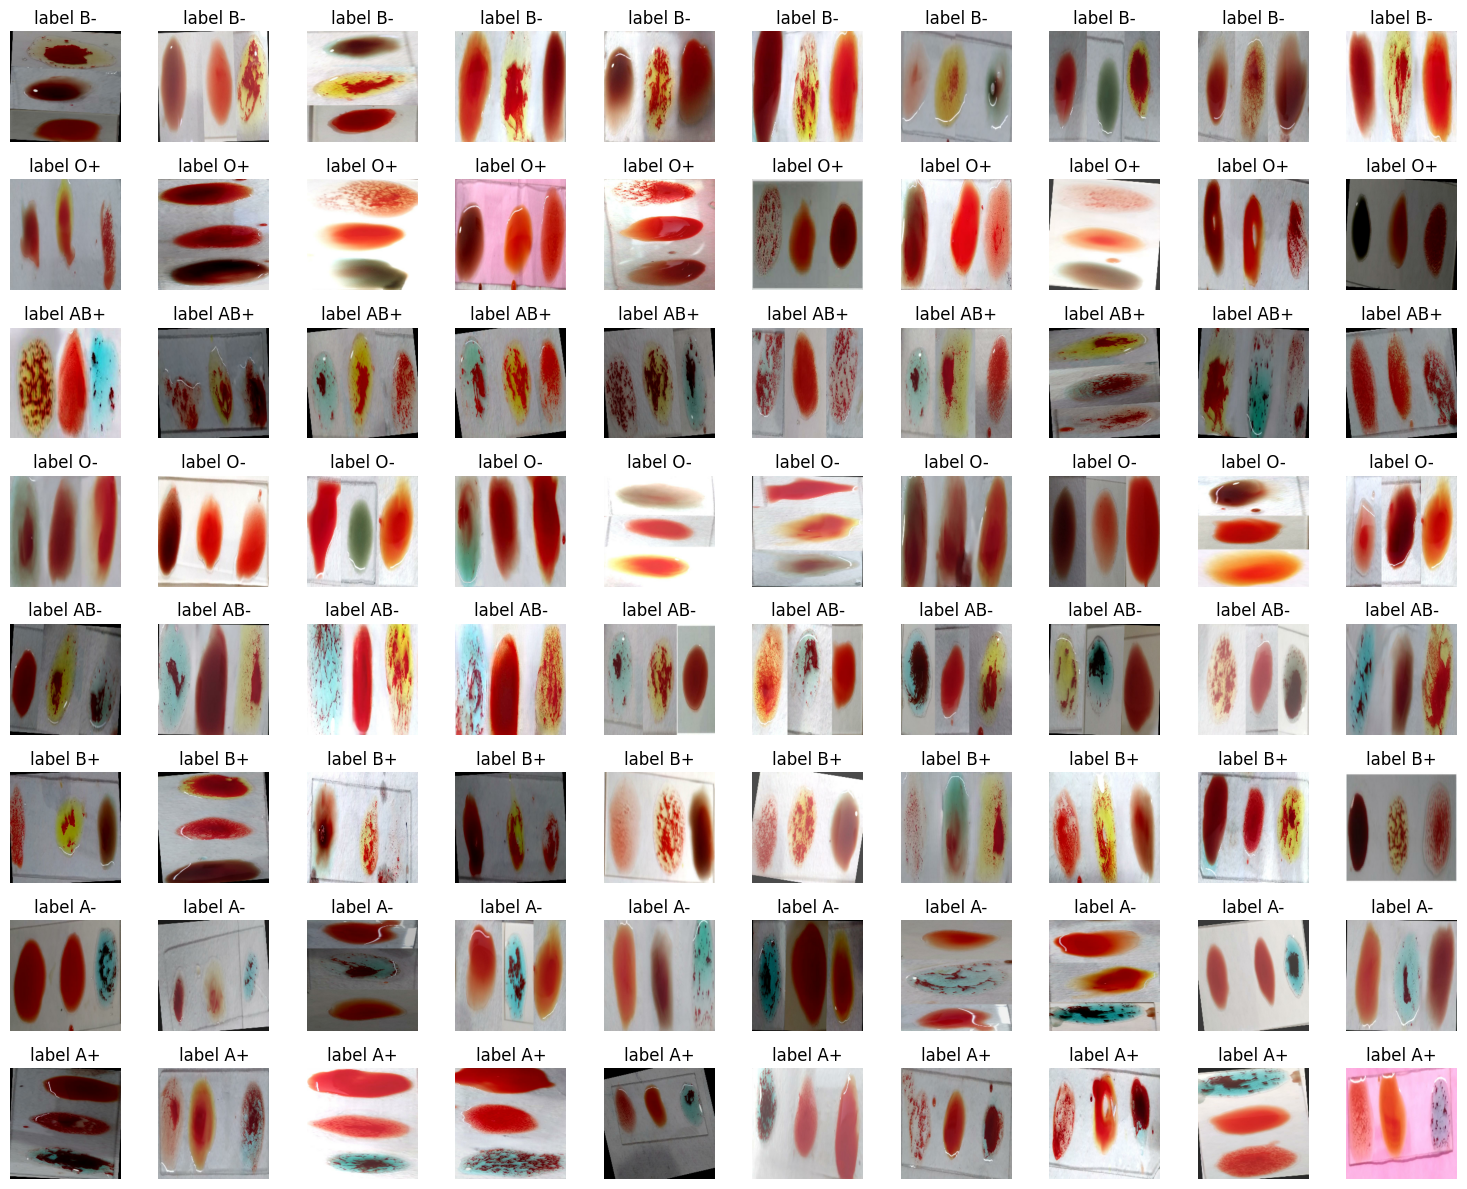

In [10]:
# create the visuals :
total_images = len(images_by_class) * 10 
cols = 10
rows = (total_images // cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 1.5))
index = 0

for label, images in images_by_class.items():
    for image in images:
        ax = axes.flat[index]
        ax.imshow(image.astype("uint8"))
        ax.axis('off')
        ax.set_title(f"label {ds_train.class_names[label]}")
        index += 1

plt.tight_layout()
plt.show()

### 5. DATA preprocessing (visualisate the length on each class):

In [11]:
# Load the data :
ds_visualization = tf.keras.preprocessing.image_dataset_from_directory(
    path_dir, # the directoryy
    labels = "inferred", # using the labels that exist in the folderss
    label_mode = "categorical", #one hot
    image_size = (image_height, image_width),
    shuffle = True,
    seed = 42
)

Found 14962 files belonging to 8 classes.


In [12]:
# extract the labels:
labels = []
for _, label in ds_visualization:
    for i in label:
        labels.append(i)

labels = np.array(labels)
print(f"Shape of labels: {labels.shape}")

Shape of labels: (14962, 8)


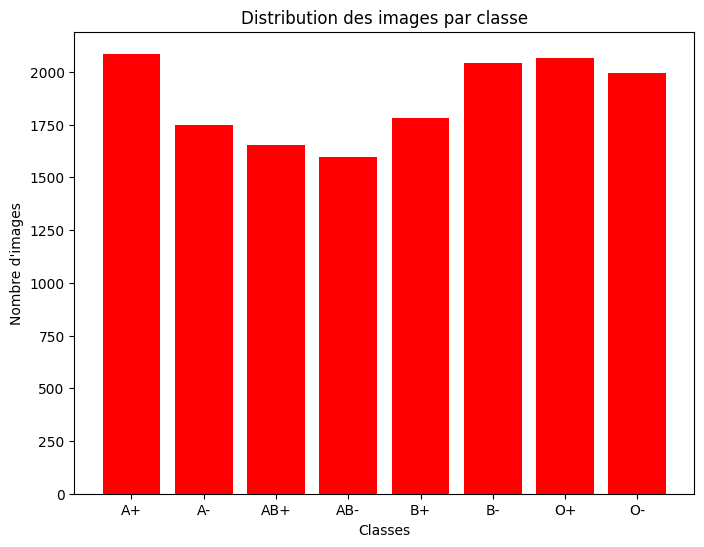

In [13]:
# one hot --> indices
labels_indices = [np.argmax(label) for label in labels]

# compute the number of images in each class
unique, counts = np.unique(labels_indices, return_counts=True)

# define the class names :
class_names = ds_visualization.class_names

# visuaa
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, tick_label=[class_names[i] for i in unique], color='red')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par classe')
plt.xticks(unique)  
plt.show()

### 6. DATA Noramlisation :

In [9]:
# calculate the mean and std :
normalizer = Normalization(axis=-1)

normalizer.adapt(ds_train.map(lambda x, _: x))  

def normalize_with(image, label):
    image = normalizer(image)  
    return image, label

ds_train = ds_train.map(normalize_with)
ds_val = ds_val.map(normalize_with)
ds_test = ds_test.map(normalize_with)

### 7. verify the existing GPUs :

In [10]:
# Verify the GPU
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 8. Define the first model : (inspiration from VGG blocks CNN algorithm):

In [11]:
def model_insper_1(input_shape=(200, 200, 3), classes=8):
    # Input Layer
    X_input = Input(input_shape)
    
    # 1st Conv Block
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(X_input)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.25)(x)  # Dropout
    
    # 2nd Conv Block
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.25)(x)  # Dropout
    
    # 3rd Conv Block
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.3)(x)  # Dropout
    
    # 4th Conv Block
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.3)(x)  # Dropout
    
    # 5th Conv Block
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.3)(x)  # Dropout
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Dropout(0.5)(x)  # Dropout
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = Dropout(0.5)(x)  # Dropout
    output = Dense(units=classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=X_input, outputs=output)
    
    return model


In [17]:
# defien the model and display the caracteristics :
model3 = model_insper_1(input_shape = (200, 200, 3), classes = 8)
print(model3.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,342,984 (512.48 MB)

 Trainable params: 134,318,152 (512.38 MB)

 Non-trainable params: 24,832 (97.00 KB)

None


#### 1. define the metrics (learning rate , optimazer ...):

In [18]:
# set the param of the moidel:
opt = tf.keras.optimizers.SGD(learning_rate=0.00015)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### 2. Train the model (using the SGD AND ALPHA = 0.00015)  :

In [19]:
# train the model :
history = model3.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 116s 328ms/step - accuracy: 0.1289 - loss: 3.3774 - val_accuracy: 0.1359 - val_loss: 2.5915
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.1361 - loss: 3.3522 - val_accuracy: 0.1562 - val_loss: 2.4573
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.1412 - loss: 3.2442 - val_accuracy: 0.1786 - val_loss: 2.4081
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.1582 - loss: 3.1658 - val_accuracy: 0.1736 - val_loss: 2.5616
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.2060 - loss: 2.9028 - val_accuracy: 0.2019 - val_loss: 2.6530
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.2112 - loss: 2.7969 - val_accuracy: 0.2102 - val_loss: 2.8699
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.2448 - loss: 2.6143 - val_accuracy: 0.2224 - val_loss: 3.1318
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.2841 - loss: 

#### 3. Evaluate the model :

In [20]:
# evaluate the model:
model3.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4363 - loss: 2.2293


[2.2100532054901123, 0.44455644488334656]

<ipython-input-21-4b4bac2f31c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-21-4b4bac2f31c4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

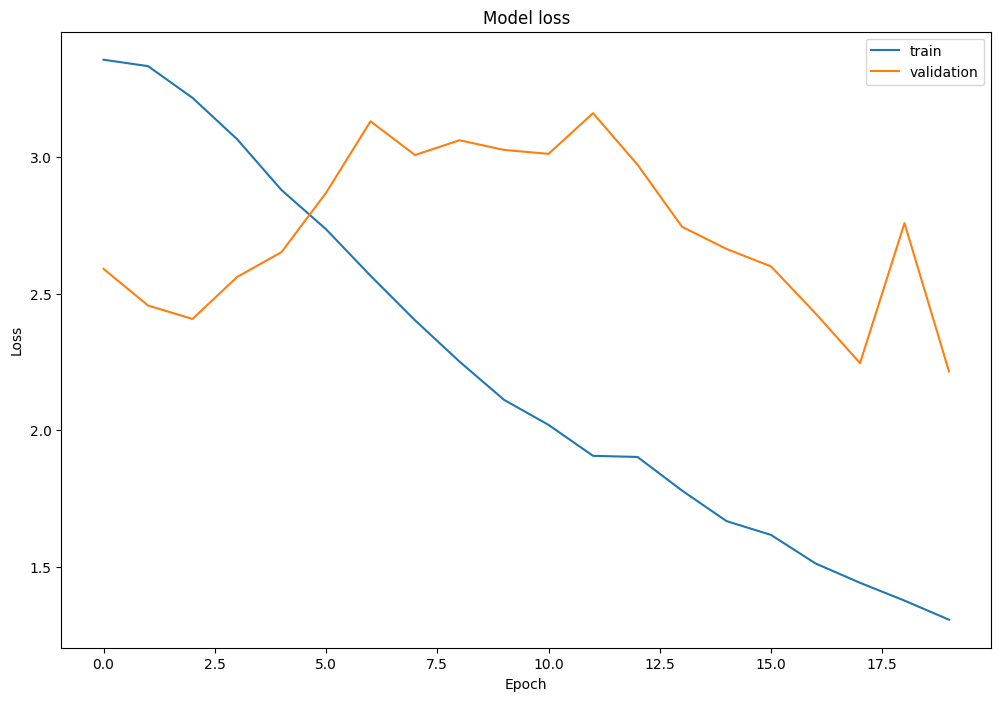

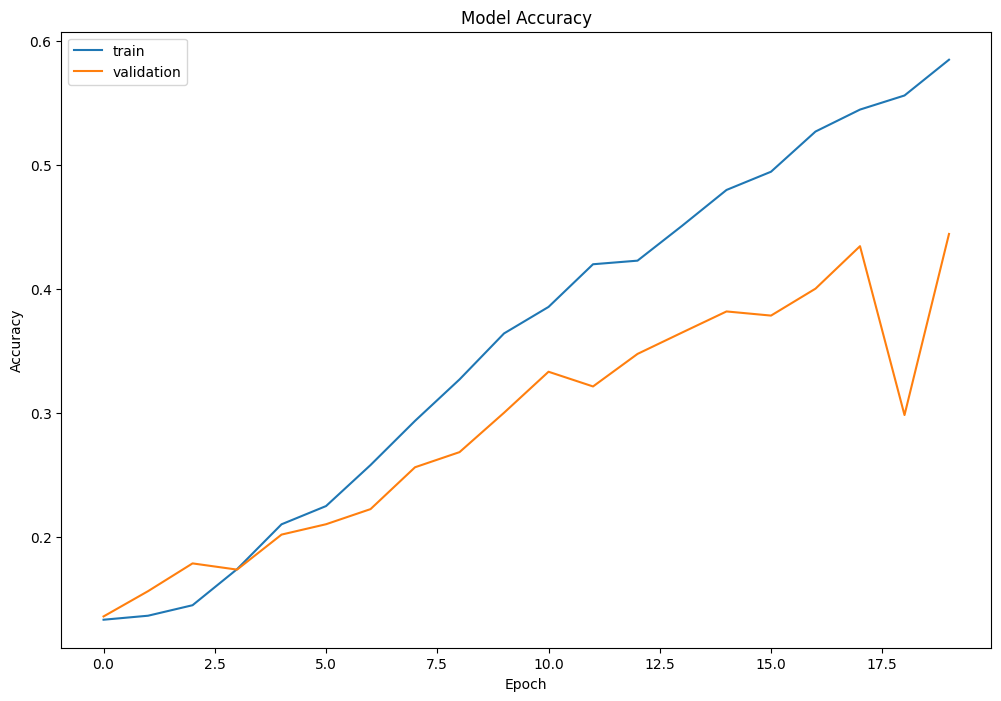

In [21]:
# visualisation accuracy and loss:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

#### 4.set the learning rate to 0.001 :

In [22]:
# set the param of the moidel:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# train the model :
history1 = model3.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 87s 278ms/step - accuracy: 0.5398 - loss: 1.4827 - val_accuracy: 0.3869 - val_loss: 3.2868
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.6223 - loss: 1.1763 - val_accuracy: 0.6140 - val_loss: 1.4005
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.7055 - loss: 0.8905 - val_accuracy: 0.7139 - val_loss: 0.9835
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.7751 - loss: 0.6854 - val_accuracy: 0.7395 - val_loss: 1.0337
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.8089 - loss: 0.6011 - val_accuracy: 0.6355 - val_loss: 1.4212
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.8371 - loss: 0.5230 - val_accuracy: 0.8202 - val_loss: 0.6315
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 253ms/step - accuracy: 0.8617 - loss: 0.4397 - val_accuracy: 0.8372 - val_loss: 0.5445
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 71s 254ms/step - accuracy: 0.8701 - loss: 0

In [24]:
# evaluate the model:
model3.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8936 - loss: 0.4011


[0.4168354272842407, 0.8867607712745667]

<ipython-input-26-fff5abe85729>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-26-fff5abe85729>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

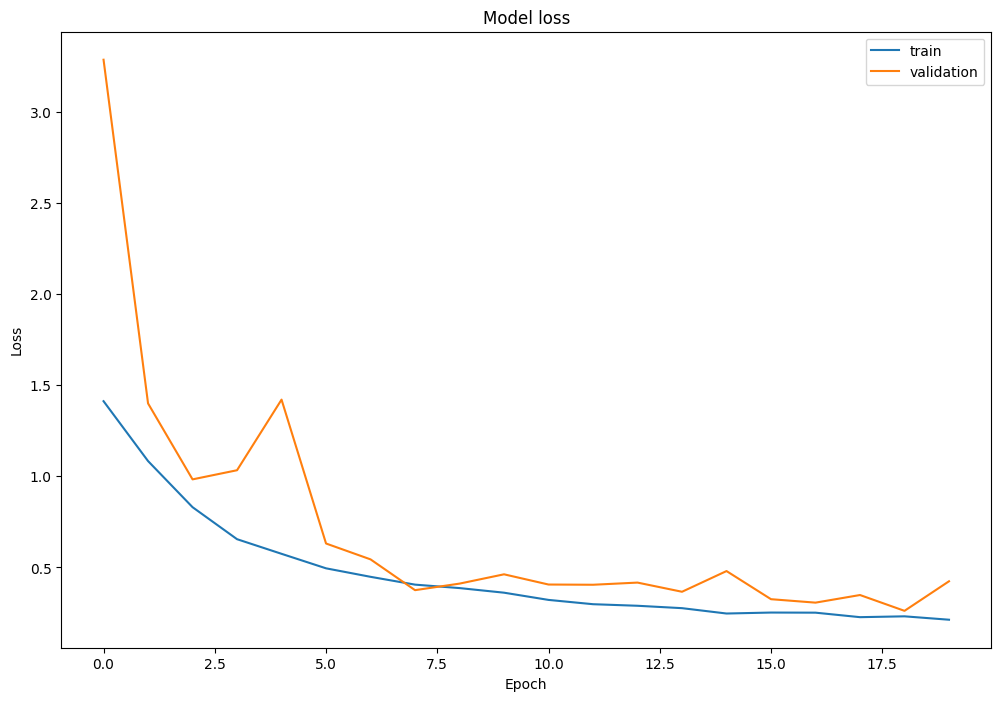

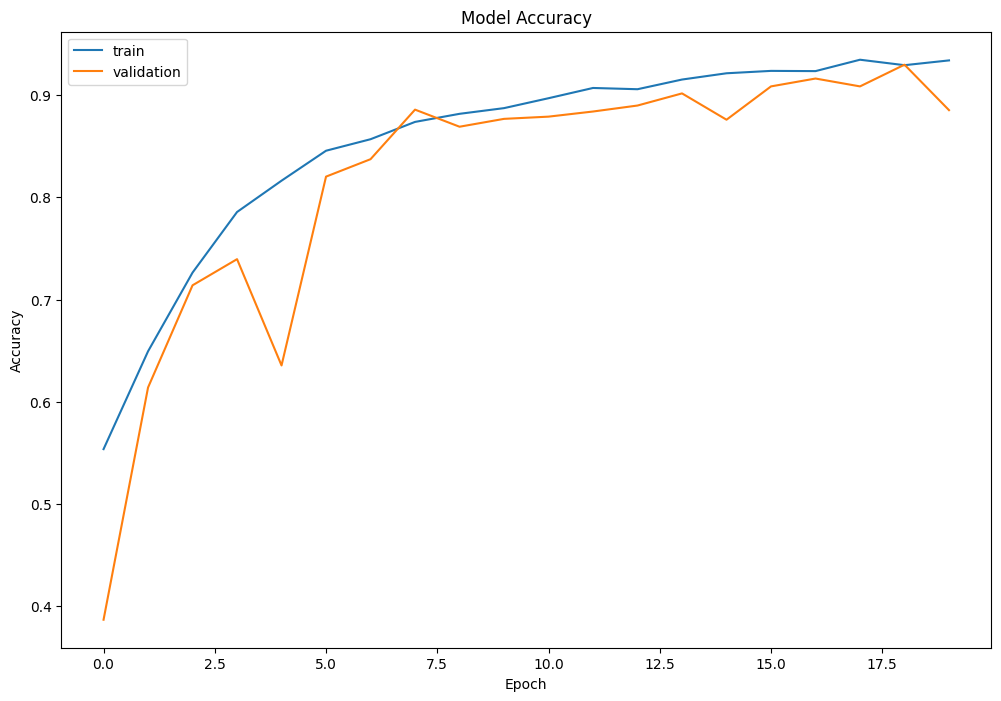

In [26]:
# visualisation accuracy and loss:
df_loss_acc = pd.DataFrame(history1.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [29]:
# train the model :
history2 = model3.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 101s 297ms/step - accuracy: 0.2428 - loss: 3.6606 - val_accuracy: 0.1842 - val_loss: 24.9023
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.6340 - loss: 1.4741 - val_accuracy: 0.6407 - val_loss: 3.5097
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.7395 - loss: 1.1011 - val_accuracy: 0.8133 - val_loss: 1.4337
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.8188 - loss: 0.7573 - val_accuracy: 0.7963 - val_loss: 1.2642
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.8424 - loss: 0.6982 - val_accuracy: 0.8680 - val_loss: 0.8013
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.8498 - loss: 0.7268 - val_accuracy: 0.8499 - val_loss: 0.7052
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.8633 - loss: 0.6241 - val_accuracy: 0.8033 - val_loss: 1.8420
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.8699 - loss:

<ipython-input-31-31ecedf23f28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-31-31ecedf23f28>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

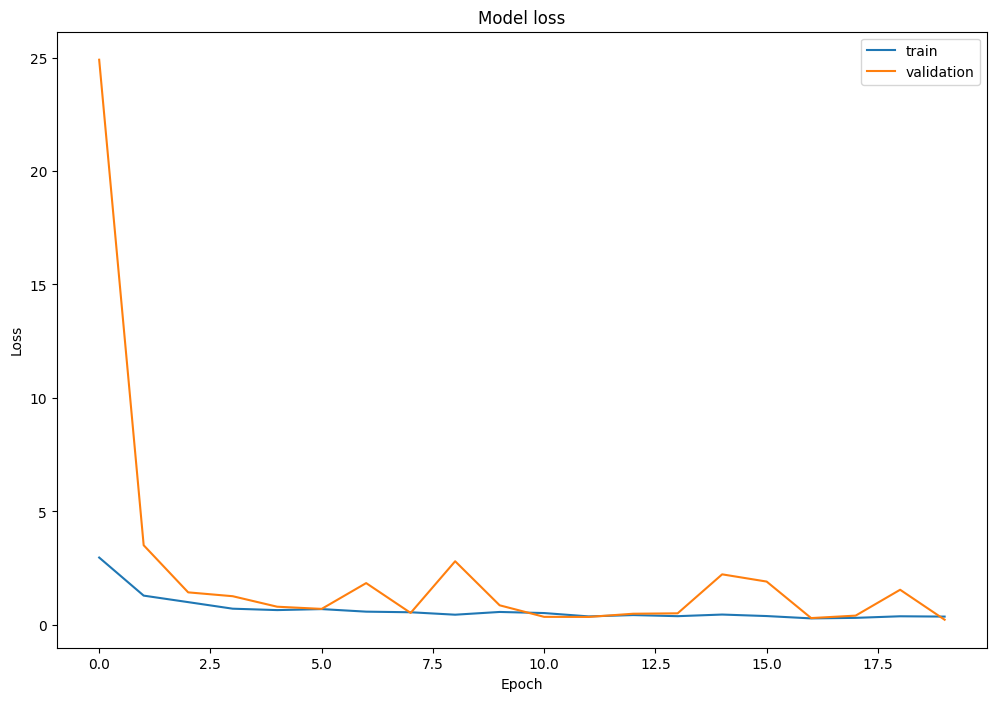

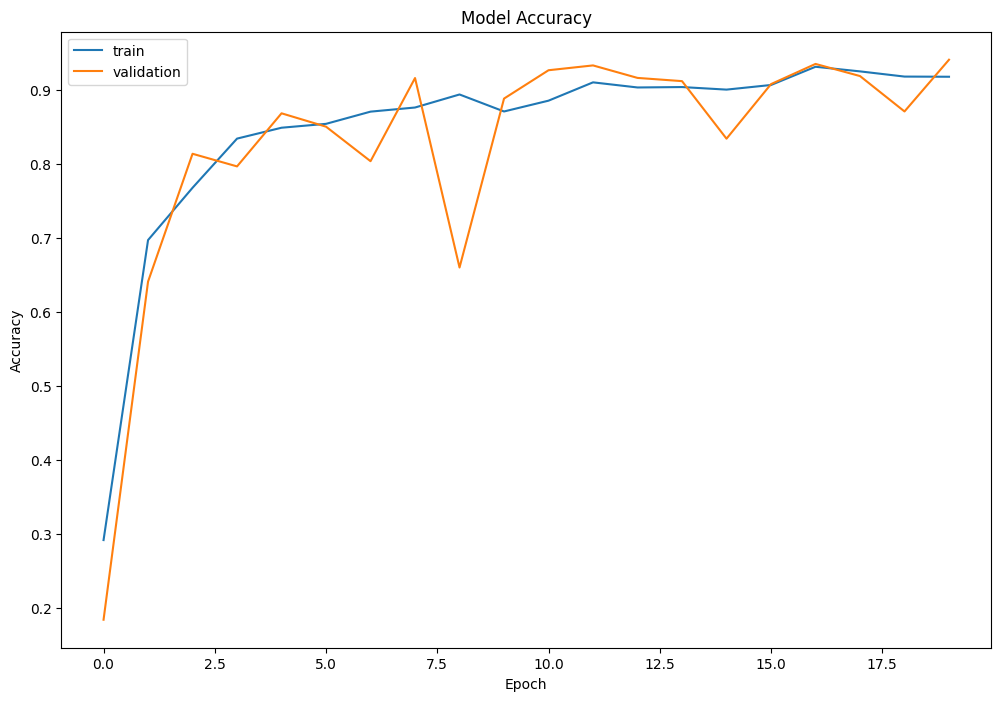

In [31]:
# visualisation accuracy and loss:
df_loss_acc = pd.DataFrame(history2.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [30]:
# evaluate the model:
model3.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9444 - loss: 0.2138


[0.22159400582313538, 0.9401881694793701]

#### 5. evualuate the model using the advanced metrics (precision, recal, F1score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

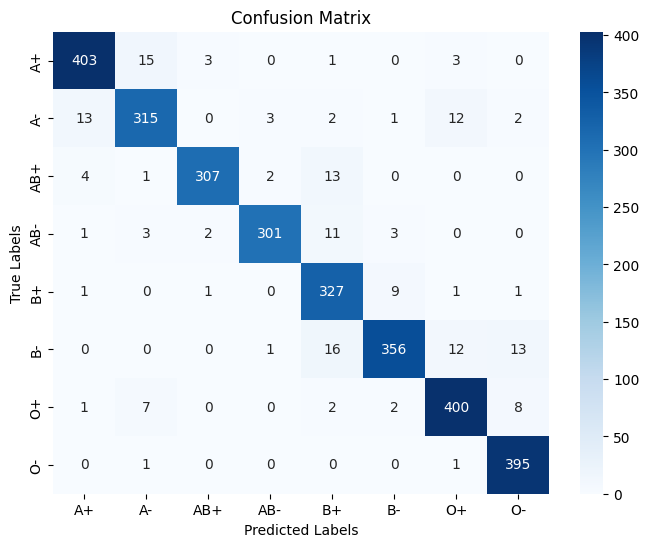

In [32]:
# evaluate the model :
# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = path_dir

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model3.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model3.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [34]:
# save the model :
model3.save('model_SGD_BLOOD.h5') 

#### 6. change the optimazer to ADAM with the learning rate = 0.00015 :

In [12]:
# set the param of the moidel:
model4 = model_insper_1(input_shape = (200, 200, 3), classes = 8)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
histo5 = model4.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 127s 346ms/step - accuracy: 0.3002 - loss: 2.8537 - val_accuracy: 0.1394 - val_loss: 12.3892
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.6944 - loss: 1.1233 - val_accuracy: 0.5157 - val_loss: 2.7563
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.8113 - loss: 0.6918 - val_accuracy: 0.7600 - val_loss: 0.9097
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.8564 - loss: 0.5461 - val_accuracy: 0.7525 - val_loss: 1.0903
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.8810 - loss: 0.4427 - val_accuracy: 0.7901 - val_loss: 0.9898
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.8982 - loss: 0.3715 - val_accuracy: 0.7675 - val_loss: 1.2167
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.9136 - loss: 0.3036 - val_accuracy: 0.8715 - val_loss: 0.5466
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.9209 - loss:

In [14]:
# evaluate the model:
model4.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9599 - loss: 0.2076


[0.21682603657245636, 0.9596773982048035]

<ipython-input-16-e8c75440be11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-16-e8c75440be11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

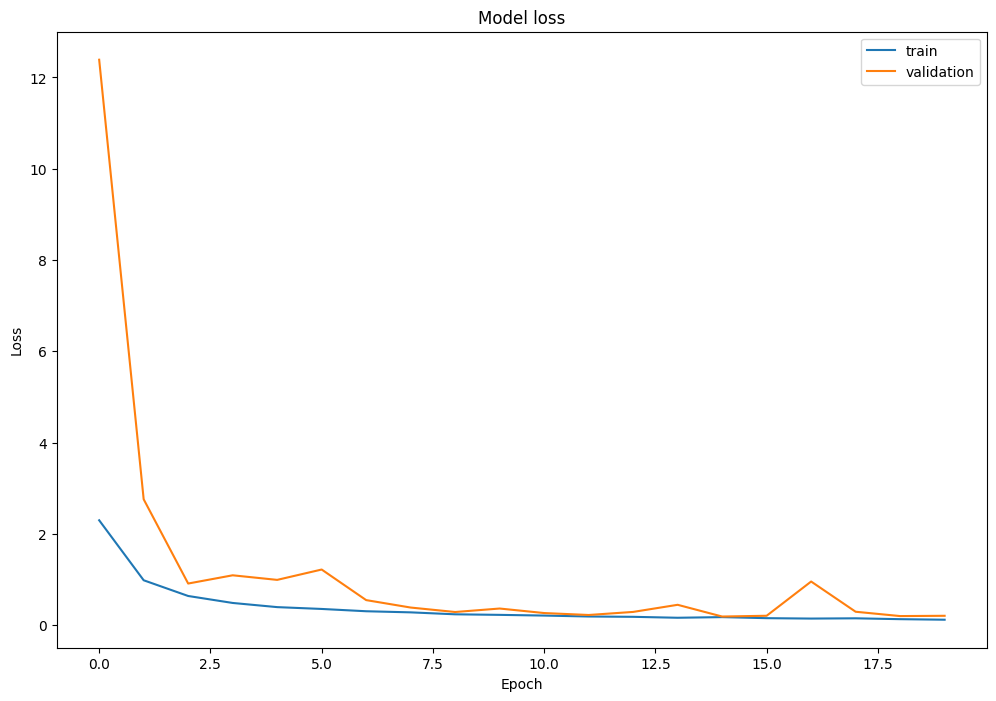

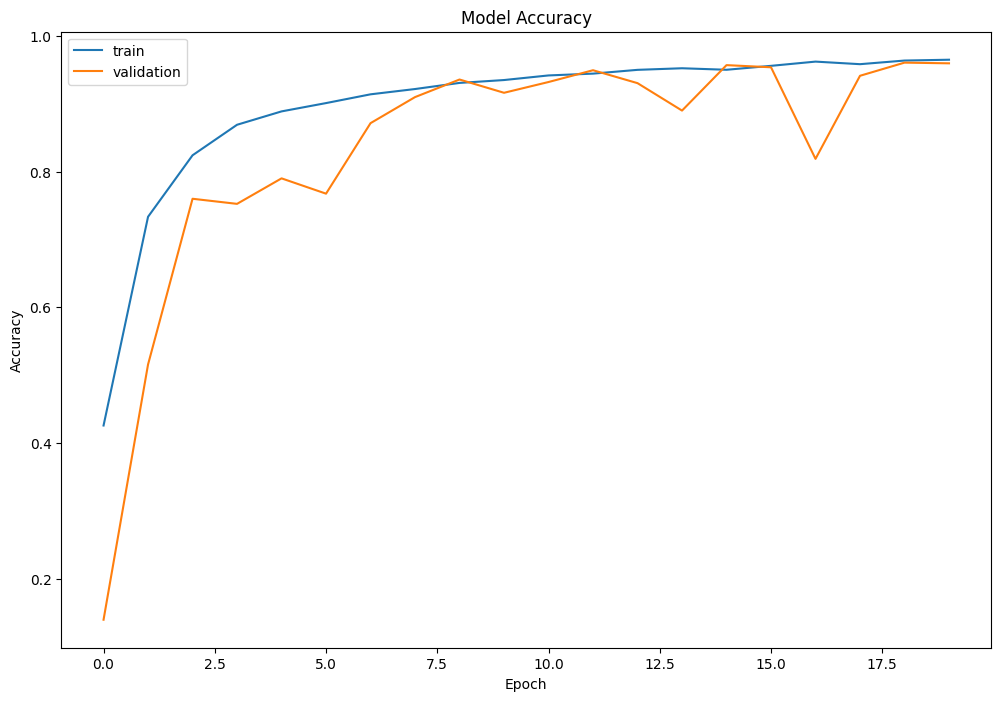

In [16]:
# visualisation accuracy and loss:
df_loss_acc = pd.DataFrame(histo5.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

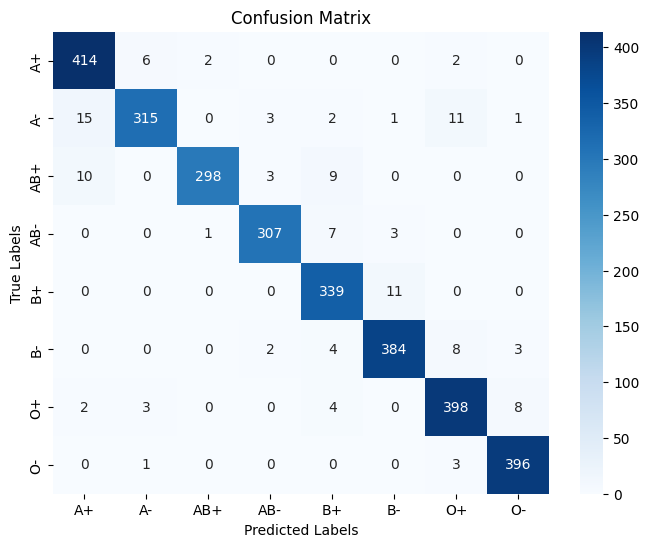

In [17]:
# evaluate the model :
# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = path_dir

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model4.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model4.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [20]:
# save the model
model4.save('model_blood_detection.h5')

### 9. Define the second model : (inspiration from RESNET blocks CNN algorithm)

In [21]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    documentttaaatioon
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    
    ## AddING shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [22]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    documentationnns
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    # THE CONVOLUTIONAL BLOCK(RESNET S)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [23]:
def ResNet50_v2(input_shape=(60, 60, 3), classes=8, training=False):
    """
    ResNet50_v2 avec Dropout pour éviter l'overfitting.
    """
    # Définir l'entrée comme un tenseur avec la forme input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Ajouter Dropout pour réduire l'overfitting
    X = Dropout(0.2)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = Dropout(0.3)(X)  # Ajout d'un Dropout après le bloc de convolution

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, filters=[128, 128, 512])
    X = identity_block(X, 3, filters=[128, 128, 512])
    X = identity_block(X, 3, filters=[128, 128, 512])

    X = Dropout(0.3)(X)  # Dropout après le stage 3

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, filters=[256, 256, 1024])
    X = identity_block(X, 3, filters=[256, 256, 1024])
    X = identity_block(X, 3, filters=[256, 256, 1024])
    X = identity_block(X, 3, filters=[256, 256, 1024])
    X = identity_block(X, 3, filters=[256, 256, 1024])

    X = Dropout(0.4)(X)  # Dropout après le stage 4

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, filters=[512, 512, 2048])
    X = identity_block(X, 3, filters=[512, 512, 2048])

    # Dropout après le stage 5
    X = Dropout(0.4)(X)

    # AVGPOOL
    X = AveragePooling2D((2, 2))(X)

    # Ajouter un Dropout avant la couche fully connected
    X = Dropout(0.5)(X)

    # Couche de sortie
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Créer le modèle
    model = Model(inputs=X_input, outputs=X)

    return model

In [25]:
# defien the model and display the caracteristics :
model9 = ResNet50_v2(input_shape = (200, 200, 3), classes = 8)
print(model9.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 206, 206, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 100, 100, 64)   │          9,472 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_68    │ (None, 100, 100, 64)   │            256 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_49             │ (None, 100, 100, 64)   │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 49, 49, 64)     │              0 │ activation_49[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 49, 49, 64)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 49, 49, 64)     │          4,160 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_69    │ (None, 49, 49, 64)     │            256 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 49, 49, 64)     │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 49, 49, 64)     │         36,928 │ activation_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_70    │ (None, 49, 49, 64)     │            256 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_51             │ (None, 49, 49, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 49, 49, 256)    │         16,640 │ activation_51[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 49, 49, 256)    │         16,640 │ dropout_13[0][0]       │
├──────────────────────

 Total params: 23,735,176 (90.54 MB)

 Trainable params: 23,682,056 (90.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [26]:
# set the param of the moidel:
opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
model9.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
#train the model :
h = model9.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 130s 269ms/step - accuracy: 0.1407 - loss: 5.2623 - val_accuracy: 0.2614 - val_loss: 1.9349
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - accuracy: 0.3653 - loss: 1.6953 - val_accuracy: 0.3010 - val_loss: 2.6108
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - accuracy: 0.5742 - loss: 1.1992 - val_accuracy: 0.2667 - val_loss: 4.4652
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.6659 - loss: 0.9658 - val_accuracy: 0.1691 - val_loss: 8.7582
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - accuracy: 0.7651 - loss: 0.7245 - val_accuracy: 0.7757 - val_loss: 0.7003
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.8156 - loss: 0.5867 - val_accuracy: 0.6970 - val_loss: 1.0720
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - accuracy: 0.8560 - loss: 0.4631 - val_accuracy: 0.8486 - val_loss: 0.4797
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.8703 - loss: 

In [29]:
# add 20 epoch
h = model9.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.9430 - loss: 0.1901 - val_accuracy: 0.9258 - val_loss: 0.2509
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.9363 - loss: 0.1925 - val_accuracy: 0.9413 - val_loss: 0.2033
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.9388 - loss: 0.1947 - val_accuracy: 0.8611 - val_loss: 0.6023
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.9493 - loss: 0.1638 - val_accuracy: 0.8964 - val_loss: 0.3933
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.9283 - loss: 0.2381 - val_accuracy: 0.8633 - val_loss: 0.4872
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.9436 - loss: 0.1823 - val_accuracy: 0.8800 - val_loss: 0.4471
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.9513 - loss: 0.1531 - val_accuracy: 0.9066 - val_loss: 0.3186
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.9515 - loss: 0

In [30]:
# evaluate the model:
model9.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9037 - loss: 0.3941


[0.395233690738678, 0.9069220423698425]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

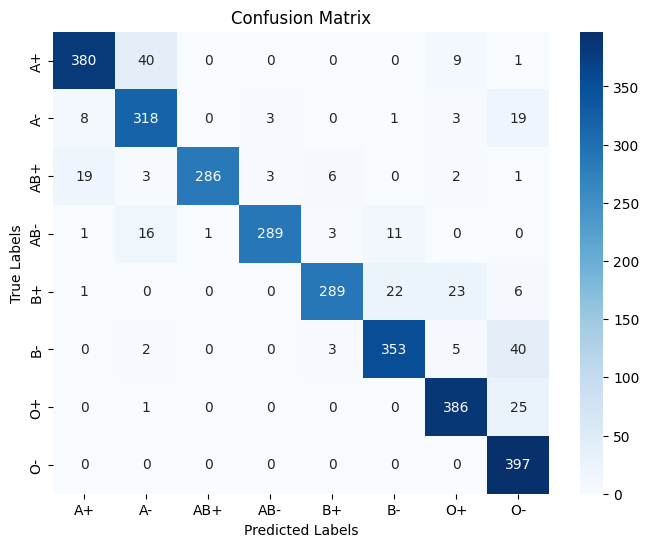

In [31]:
# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = path_dir

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model9.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model9
    .predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

### 9. Define the third model : (inspiration from ALEXNET CNN algorithm):

In [36]:
# Define the AlexNet model
def create_alexnet(input_shape=(200, 200, 3), num_classes=8):
    model = models.Sequential([
        
        # 1st Convolutional Layer + Max Pooling
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # 2nd Convolutional Layer + Max Pooling
        layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # 3rd Convolutional Layer
        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),

        # 4th Convolutional Layer
        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),

        # 5th Convolutional Layer + Max Pooling
        layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # Flattening the feature maps
        layers.Flatten(),

        # Fully Connected Layer 1
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Fully Connected Layer 2
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [44]:
# Create the model
alexnetmodel = create_alexnet(input_shape = (200, 200, 3), num_classes= 8)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
alexnetmodel.compile(optimizer=opt,  # Use Adam optimizer
                loss='categorical_crossentropy',  # Cross-entropy loss for multi-class classification
                metrics=['accuracy'])

In [45]:
# Model summary
alexnetmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)                  │ (None, 48, 48, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 23, 23, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 23, 23, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 11, 11, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 11, 11, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 11, 11, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,779,784 (178.45 MB)

 Trainable params: 46,779,784 (178.45 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
#train the model :
alexnetmodel.fit(ds_train, epochs=10, validation_data=(ds_validation))

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.2753 - loss: 1.7875 - val_accuracy: 0.4455 - val_loss: 32.3194
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6801 - loss: 0.9001 - val_accuracy: 0.6795 - val_loss: 15.4347
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.8033 - loss: 0.5823 - val_accuracy: 0.5040 - val_loss: 62.1142
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8538 - loss: 0.4298 - val_accuracy: 0.3660 - val_loss: 84.4326
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8850 - loss: 0.3344 - val_accuracy: 0.7663 - val_loss: 15.3915
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8970 - loss: 0.2999 - val_accuracy: 0.7596 - val_loss: 18.5373
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9103 - loss: 0.2632 - val_accuracy: 0.8497 - val_loss: 15.8660
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9434 - loss: 0.

In [47]:
#train the model :
alexnetmodel.fit(ds_train, epochs=20, validation_data=(ds_validation))

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9688 - loss: 0.0920 - val_accuracy: 0.7197 - val_loss: 34.6921
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9612 - loss: 0.1215 - val_accuracy: 0.6130 - val_loss: 68.8429
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9654 - loss: 0.1105 - val_accuracy: 0.8188 - val_loss: 20.2289
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9554 - loss: 0.1327 - val_accuracy: 0.7892 - val_loss: 21.5104
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9747 - loss: 0.0767 - val_accuracy: 0.7779 - val_loss: 27.9571
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9550 - loss: 0.1324 - val_accuracy: 0.8444 - val_loss: 15.4925
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9778 - loss: 0.0699 - val_accuracy: 0.8235 - val_loss: 25.2729
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9810 - loss: 0.

In [11]:


def create_alexnet(input_shape=(200, 200, 3), num_classes=8):
    model = models.Sequential([
        
        # 1st Convolutional Layer + Max Pooling
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Batch Normalization
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # 2nd Convolutional Layer + Max Pooling
        layers.Conv2D(256, (5, 5), padding="same", activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # 3rd Convolutional Layer
        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization

        # 4th Convolutional Layer
        layers.Conv2D(384, (3, 3), padding="same", activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization

        # 5th Convolutional Layer + Max Pooling
        layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        # Flattening the feature maps
        layers.Flatten(),

        # Fully Connected Layer 1
        layers.Dense(4096, activation='relu',),  # L2 Regularization
        layers.BatchNormalization(),  # Batch Normalization
        layers.Dropout(0.5),

        # Fully Connected Layer 2
        layers.Dense(4096, activation='relu'),  # L2 Regularization
        layers.BatchNormalization(),  # Batch Normalization
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [17]:
# Create the model
alexnetmodel = create_alexnet(input_shape = (200, 200, 3), num_classes= 8)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
alexnetmodel.compile(optimizer=opt,  # Use Adam optimizer
                loss='categorical_crossentropy',  # Cross-entropy loss for multi-class classification
                metrics=['accuracy'])

In [18]:
# Model summary
alexnetmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 23, 23, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 23, 23, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 11, 11, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 11, 11, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 11, 11, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 11, 11, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 11, 11, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 46,818,056 (178.60 MB)

 Trainable params: 46,798,920 (178.52 MB)

 Non-trainable params: 19,136 (74.75 KB)

In [19]:
#train the model :
alexnetmodel.fit(ds_train, epochs=20, validation_data=(ds_val))

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.3542 - loss: 2.5927 - val_accuracy: 0.2527 - val_loss: 6.4192
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.6012 - loss: 1.5244 - val_accuracy: 0.7203 - val_loss: 0.8863
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7311 - loss: 0.9604 - val_accuracy: 0.6085 - val_loss: 1.5564
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7806 - loss: 0.7647 - val_accuracy: 0.8025 - val_loss: 0.6385
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8313 - loss: 0.5807 - val_accuracy: 0.6801 - val_loss: 1.1749
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8387 - loss: 0.5657 - val_accuracy: 0.8489 - val_loss: 0.4718
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.8645 - loss: 0.4544 - val_accuracy: 0.8245 - val_loss: 0.6543
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8636 - loss: 0.4517 - 

In [20]:
# evaluate the model:
alexnetmodel.evaluate(ds_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8279 - loss: 1.1816


[1.1498583555221558, 0.8326612710952759]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

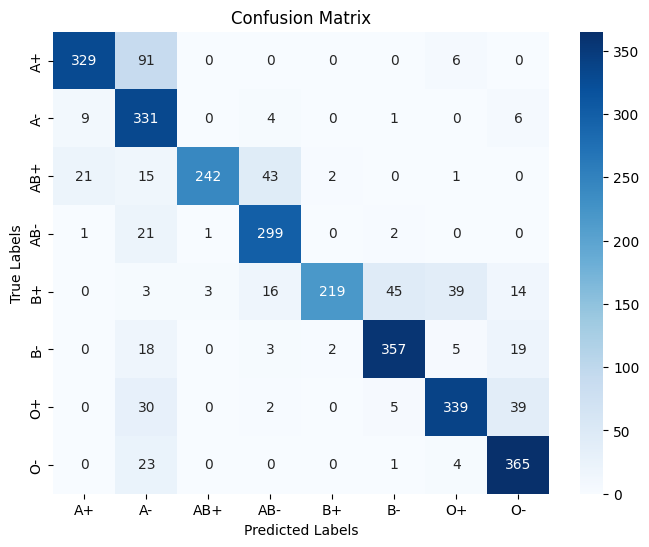

In [21]:
# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = path_dir

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = alexnetmodel.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = alexnetmodel.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

BYE !!


FROM MOAHMED AMHAL ...